# Features as images

In this notebook we extract features as images, enocde by using LBT (or HOG) and perform tests on them.

In [1]:
from enum import Enum
from pathlib import Path
from itertools import chain
from matplotlib import pyplot as plt

import numpy as np
import cv2

from skimage import feature
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier
import dlib
from collections import OrderedDict
np.random.seed(42)

TFEID_COLOR_PATH = Path('data/dfh_all/dfh_color/')

class Expression(Enum):
    ANGER = 1
    CONTEMPT = 2
    DISGUST = 3 
    FEAR = 4
    HAPPINESS = 5
    NEUTRAL = 6
    SADNESS = 7
    SURPRISE = 8

folder = {
    Expression.ANGER     : Path('dfh_anger_c'),
    Expression.CONTEMPT  : Path('dfh_contempt_c'),
    Expression.DISGUST   : Path('dfh_disguest_c'),
    Expression.FEAR      : Path('dfh_fear_c'),
    Expression.HAPPINESS : Path('dfh_happiness_c'),
    Expression.NEUTRAL   : Path('dfh_neutral_c'),
    Expression.SADNESS   : Path('dfh_sadness_c'),
    Expression.SURPRISE  : Path('dfh_surprise_c'),
}    
    
def read_images_expr(path:Path, expr:Expression):
    images = []
    labels = []
    expr_path = path.joinpath(folder[expr])
    for img_path in expr_path.iterdir():
        img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(expr.value)
    return images, labels

def read_images(path):
    images, labels = [], []
    for expr in Expression:
        expr_images, expr_labels = read_images_expr(path, expr=expr)
        print(expr, len(expr_images), len(expr_labels))
        images+=expr_images
        labels+=expr_labels
    return images, labels

tfeid_images, tfeid_labels = read_images(TFEID_COLOR_PATH)

Expression.ANGER 34 34
Expression.CONTEMPT 68 68
Expression.DISGUST 40 40
Expression.FEAR 40 40
Expression.HAPPINESS 40 40
Expression.NEUTRAL 39 39
Expression.SADNESS 39 39
Expression.SURPRISE 36 36


In [2]:
def show_metrics(model, pred_y, test_x, test_y):
    print(f'Accuracy: {accuracy_score(test_y, pred_y)}')
    expr_names = [expr.name for expr in Expression]
    plot_confusion_matrix(model, test_x, test_y,
                          display_labels=np.array(expr_names),
                          xticks_rotation=45.0)
    plt.show() 
    print(classification_report(test_y,pred_y,
                                target_names=expr_names,
                                zero_division=0))

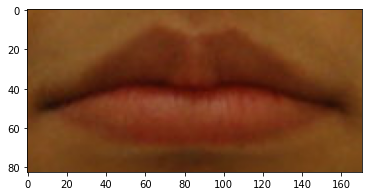

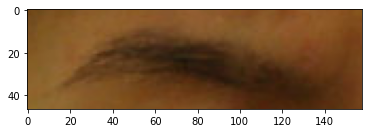

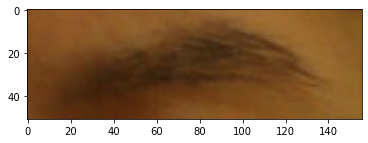

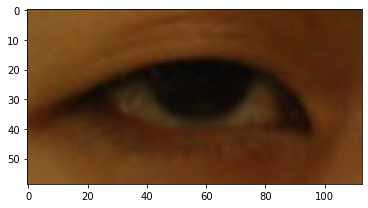

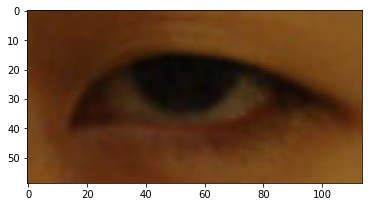

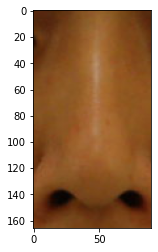

In [3]:
FACIAL_LANDMARKS_INDEXES = OrderedDict([
    ("Mouth", (48, 68)),
    ("Right_Eyebrow", (17, 22)),
    ("Left_Eyebrow", (22, 27)),
    ("Right_Eye", (36, 42)),
    ("Left_Eye", (42, 48)),
    ("Nose", (27, 35)),
    # ("Jaw", (0, 17))
])


detector = dlib.get_frontal_face_detector()

predictor = dlib.shape_predictor("data/tools/shape_predictor_68_face_landmarks.dat")


def get_images(img_pulp):

    gray = cv2.cvtColor(src=img_pulp, code=cv2.COLOR_RGB2GRAY)

    # Use detector to find a face on the image
    face_coord = detector(gray)[0]

    face = img_pulp[face_coord.top():face_coord.bottom(), face_coord.left():face_coord.right()]

    # Create landmark object
    landmarks = predictor(image=gray, box=face_coord)
    features = []

    # Going through each landmark (nose, eye)
    for name, ind in FACIAL_LANDMARKS_INDEXES.items():
        feature = []
        for i in range(ind[0], ind[1]):
            feature.append([landmarks.part(i).x, landmarks.part(i).y])

        # Creating teh image from coordinates and increasing rectangle 
        # so that some vital information around the landmark is not lost
        f_x, f_y = zip(*feature)
        if name == 'Nose':
            features.append(img_pulp[np.min(f_y)-5:np.max(f_y)+5,np.min(f_x)-10:np.max(f_x)+22])
        elif name == 'Right_Eye' or name=="Left_Eye":
            features.append(img_pulp[np.min(f_y)-20:np.max(f_y)+20,np.min(f_x)-20:np.max(f_x)+22])
        else:
            features.append(img_pulp[np.min(f_y)-10:np.max(f_y)+10,np.min(f_x)-10:np.max(f_x)+10])
    return features

img_pulp = cv2.cvtColor(cv2.imread('data/dfh_un-rimmed/dfh_anger_x/f01_dfh_ax.jpg'),cv2.COLOR_BGR2RGB)
for i in get_images(img_pulp):
    plt.imshow(i); plt.show()

In [4]:
np.random.seed(42)


# Preprocessing stage (extracting the face from input) was done together with feature extraction
# because it is more efficient and convinient
def preprocess_single(img):
    return img

def preprocess(images):
    return np.array([preprocess_single(img) for img in images])
    
def hog(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    fd = feature.hog(img_gray, orientations=8,
                    pixels_per_cell=(12,12), # changing these parameters gave increase of accurace form 42 to 54%
                    cells_per_block=(2,2),
                    block_norm='L2',
                    feature_vector=True)
    hist, _ = np.histogram(
        fd.ravel(),
        bins= 17,
    )

    hist = hist.astype(np.float)
    hist /= (np.sum(hist)+1e-5)
    return hist
        

def lbp(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    numpoints = 14
    radius = 4
    lbp = feature.local_binary_pattern(img_gray, numpoints, radius)
    hist, _ = np.histogram(
        lbp.ravel(),
        bins= numpoints+3,
    )

    hist = hist.astype(np.float)
    hist /= (np.sum(hist)+1e-5)
    return hist

def extract_image(img, method=lbp):
    features = get_images(img)
    ret = np.array([])
    for img in features:
        ret = np.append(ret, method(img))
    return ret.ravel()

def extract_features(images, method):
    return np.array([method(img) for img in images])


# tfeid_x = preprocess(tfeid_images)
tfeid_x = extract_features(tfeid_images, method=extract_image)
tfeid_labels = np.array(tfeid_labels)

train_x, test_x, train_y, test_y = train_test_split(tfeid_x, tfeid_labels, stratify=tfeid_labels)

In [5]:
np.random.seed(42)

# 'rbf', 'sigmoid'
param_grid = {
    'base_estimator':[DecisionTreeClassifier(max_depth=7)],
    'learning_rate':np.logspace(-3, 1, 50),
}

grid_search = GridSearchCV(AdaBoostClassifier(), param_grid=param_grid, verbose=True, n_jobs=4)
grid_search.fit(train_x, train_y)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.4s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:   34.3s finished
{'base_estimator': DecisionTreeClassifier(max_depth=7), 'learning_rate': 1.2648552168552958}
0.7101960784313727


Accuracy: 0.6904761904761905


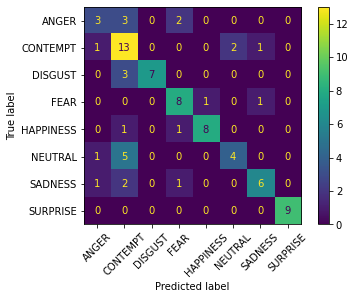

              precision    recall  f1-score   support

       ANGER       0.50      0.38      0.43         8
    CONTEMPT       0.48      0.76      0.59        17
     DISGUST       1.00      0.70      0.82        10
        FEAR       0.67      0.80      0.73        10
   HAPPINESS       0.89      0.80      0.84        10
     NEUTRAL       0.67      0.40      0.50        10
     SADNESS       0.75      0.60      0.67        10
    SURPRISE       1.00      1.00      1.00         9

    accuracy                           0.69        84
   macro avg       0.74      0.68      0.70        84
weighted avg       0.73      0.69      0.69        84



In [6]:
np.random.seed(42)

model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),learning_rate=1.5264179671752318)
model.fit(train_x, train_y)
pred_y = model.predict(test_x)

show_metrics(model, pred_y, test_x, test_y)

In [7]:
param_grid = {
    'degree':range(3,10),
    'C':np.logspace(-3, 2, 50, base = 10),
    'kernel':['poly']
}

grid_search = GridSearchCV(SVC(), param_grid=param_grid, verbose=True, n_jobs=4)
grid_search.fit(train_x, train_y)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 350 candidates, totalling 1750 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.8s
{'C': 30.88843596477485, 'degree': 3, 'kernel': 'poly'}
0.7461176470588236
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    3.5s finished
